In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-london-scikit-learn/trainLabels.csv
/kaggle/input/data-science-london-scikit-learn/train.csv
/kaggle/input/data-science-london-scikit-learn/test.csv


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingClassifier
#from sklearn import svm
from sklearn.model_selection import cross_val_score

In [3]:

data_dir = Path("/kaggle/input/data-science-london-scikit-learn/")
x_train = pd.read_csv(data_dir /'train.csv')
y_train = pd.read_csv(data_dir /'trainLabels.csv')
x_test = pd.read_csv(data_dir /'test.csv')

In [4]:

print ('training_x Shape:',x_train.shape,',training_y Shape:',y_train.shape, ',testing_x Shape:',x_test.shape)

training_x Shape: (999, 40) ,training_y Shape: (999, 1) ,testing_x Shape: (8999, 40)


In [5]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_train = y_train.ravel()
print ('training_x Shape:',x_train.shape,',training_y Shape:',y_train.shape, ',testing_x Shape:',x_test.shape)

training_x Shape: (999, 40) ,training_y Shape: (999,) ,testing_x Shape: (8999, 40)


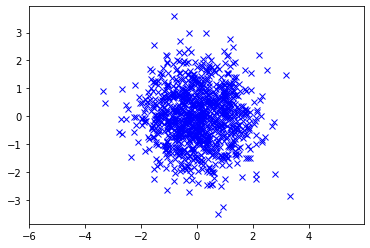

In [6]:
plt.plot(x_train[:,0], x_train[:,1], 'bx')
plt.axis('equal')
plt.show()

In [7]:
x_all = np.r_[x_train,x_test]
print( 'x_all shape :',x_all.shape)

x_all shape : (9998, 40)


In [8]:
#Preprocessing - Reduce the 40D data to 4D as identified the best no of components  = 4
from sklearn.mixture import GaussianMixture
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type)
        gmm.fit(x_all)
        bic.append(gmm.aic(x_all))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
best_gmm.fit(x_all)
x_train = best_gmm.predict_proba(x_train)
x_test = best_gmm.predict_proba(x_test)

In [9]:
print(x_train.shape)
print(x_test.shape)

(999, 4)
(8999, 4)


In [10]:
print("Best Gaussian Mixture Model:\n{}".format(best_gmm))
print(best_gmm.covariance_type)

Best Gaussian Mixture Model:
GaussianMixture(n_components=4)
full


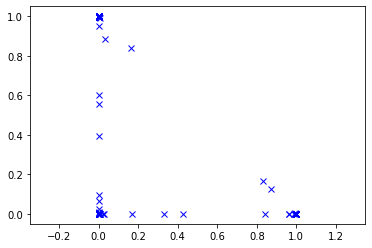

In [11]:
plt.plot(x_train[:,2], x_train[:,3], 'bx')
plt.axis('equal')
plt.show()

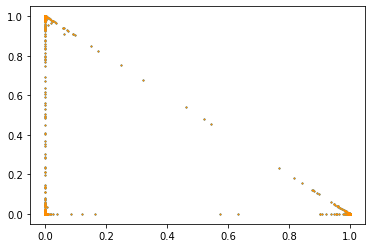

In [12]:
colors = ["navy", "turquoise", "darkorange"]
for n, color in enumerate(colors):
    data = x_test
    plt.scatter(
        data[:, 0], data[:, 1], s=0.8, color=color
    )

In [13]:
#Training
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

param_grid = dict( )
#### GRID SEARCH for BEST TUNING PARAMETERS FOR KNN #####
grid_search_knn = GridSearchCV(knn,param_grid=param_grid,cv=10,scoring='accuracy').fit(x_train,y_train)
print ('Best estimator KNN:',grid_search_knn.best_estimator_,
       'Best Score', grid_search_knn.best_estimator_.score(x_train,y_train))

knn_best = grid_search_knn.best_estimator_



Best estimator KNN: KNeighborsClassifier() Best Score 0.995995995995996


In [14]:
#### GRID SEARCH for BEST TUNING PARAMETERS FOR RandomForest #####
grid_search_rf = GridSearchCV(rf, param_grid=dict( ), verbose=3,scoring='accuracy',cv=10).fit(x_train,y_train)
print ('Best estimator RandomForest:',grid_search_rf.best_estimator_,
        'Best Score', grid_search_rf.best_estimator_.score(x_train,y_train))
rf_best = grid_search_rf.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] .................................... , score=1.000, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... , score=1.000, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .................................... , score=1.000, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.990, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=1.000, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=1.000, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.990, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=1.000, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.980, total=   0.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished


Best estimator RandomForest: RandomForestClassifier() Best Score 0.997997997997998


In [15]:
knn_best.fit(x_train,y_train)
print(knn_best.predict(x_test)[0:10])
rf_best.fit(x_train,y_train)
print(rf_best.predict(x_test)[0:10])

[0 1 0 0 0 0 1 0 0 1]
[0 1 0 0 0 0 1 0 0 1]


In [16]:
#### SCORING THE MODELS ####
print( 'Score for KNN :',cross_val_score(knn_best,x_train,y_train,cv=10,scoring='accuracy').mean())
print('Score for Random Forest :',cross_val_score(rf_best,x_train,y_train,cv=10,scoring='accuracy').mean())

Score for KNN : 0.9960000000000001
Score for Random Forest : 0.9960000000000001


In [17]:
##### FRAMING OUR SOLUTION #####
knn_best_pred = pd.DataFrame(knn_best.predict(x_test))
rf_best_pred = pd.DataFrame(rf_best.predict(x_test))
#voting_clf_pred = pd.DataFrame(clf.predict(x_test))

In [18]:
#Formatting the output as per requirement
knn_best_pred.index += 1
rf_best_pred.index += 1


In [19]:
rf_best_pred.columns = ["Solution"]
rf_best_pred["Id"] = rf_best_pred.index


In [20]:
neworder = ["Id","Solution"]
rf_best_pred = rf_best_pred.reindex(columns = neworder)
rf_best_pred.head()

,Id,Solution
1,1,0
2,2,1
3,3,0
4,4,0
5,5,0


In [21]:
rf_best_pred.shape

(8999, 2)

In [22]:
rf_best_pred.to_csv('Submission.csv',index = False,header = True)